# Doc2Vec model
## Reading data from CSV

In [1]:
import pandas as pd
import ast
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import hdbscan
import matplotlib.pyplot as plt
import umap

2024-11-19 19:15:43.512705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732040143.767616   13350 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732040143.821915   13350 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 19:15:44.365495: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def parse_list_column(column):
    return ast.literal_eval(column)

csv_file = "../../data/arxiv_processed.csv"
data = pd.read_csv(csv_file, sep=";", converters={'Processed Summary': parse_list_column})

In [3]:
data.head()

,ID,Title,Summary,Published,PDF Link,Processed Summary
0,http://arxiv.org/abs/cs/0002002v1,Uniform semantic treatment of default and auto...,We revisit the issue of connections between tw...,2000-02-03T21:44:57Z,http://arxiv.org/pdf/cs/0002002v1,"[revisit, issue, connection, two, leading, for..."
1,http://arxiv.org/abs/cs/0002003v1,On the accuracy and running time of GSAT,Randomized algorithms for deciding satisfiabil...,2000-02-04T12:53:57Z,http://arxiv.org/pdf/cs/0002003v1,"[randomized, algorithm, deciding, satisfiabili..."
2,http://arxiv.org/abs/cs/0002009v1,Syntactic Autonomy: Why There is no Autonomy w...,Two different types of agency are discussed ba...,2000-02-16T18:09:20Z,http://arxiv.org/pdf/cs/0002009v1,"[two, different, type, agency, discussed, base..."
3,http://arxiv.org/abs/cs/0003008v1,Consistency Management of Normal Logic Program...,This paper presents a method of computing a re...,2000-03-05T10:29:03Z,http://arxiv.org/pdf/cs/0003008v1,"[paper, present, method, computing, revision, ..."
4,http://arxiv.org/abs/cs/0003016v1,Abductive and Consistency-Based Diagnosis Revi...,Diagnostic reasoning has been characterized lo...,2000-03-07T11:39:53Z,http://arxiv.org/pdf/cs/0003016v1,"[diagnostic, reasoning, characterized, logical..."


## Tagging Documents and Traning Doc2Vec
Once we have the processed text, we need to tag the documents. For this purpose, we will use ID column. Let's check if all the articles have the same patter of ID:

`http://arxiv.org/abs/cs/{uniqueId}`

In [4]:
total_rows = len(data)

pattern = r"http://arxiv.org/abs/cs/(\w+)"

matching_rows = 0
non_matching_rows = []
for index, row in data.iterrows():
  id = row['ID']
  if re.match(pattern, str(id)):
    matching_rows += 1
  else:
    non_matching_rows.append(index)

print(f"Total number of rows: {total_rows}")
print(f"Number of rows with matching ID pattern: {matching_rows}")
print(f"Example of non-matching ID pattern row: {data.loc[non_matching_rows[0]]['ID']}")

Total number of rows: 34575
Number of rows with matching ID pattern: 477
Example of non-matching ID pattern row: http://arxiv.org/abs/0704.2010v2


We see that we cannot use part of ID as unique TAG. So we will use number of row as id for text and train the Doc2Vec model.

In [4]:
tagged_data = [TaggedDocument(words=row['Processed Summary'], tags=[str(index)]) for index, row in data.iterrows()]

model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

## Clustering Document Vectors
Once the model is trained, extract document vectors and apply clustering. We will use HDSCAN for simple clustering

In [5]:
vectors = [model.dv[str(index)] for index, row in data.iterrows()]

In [6]:
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine').fit_transform(vectors)

In [7]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [9]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(vectors)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

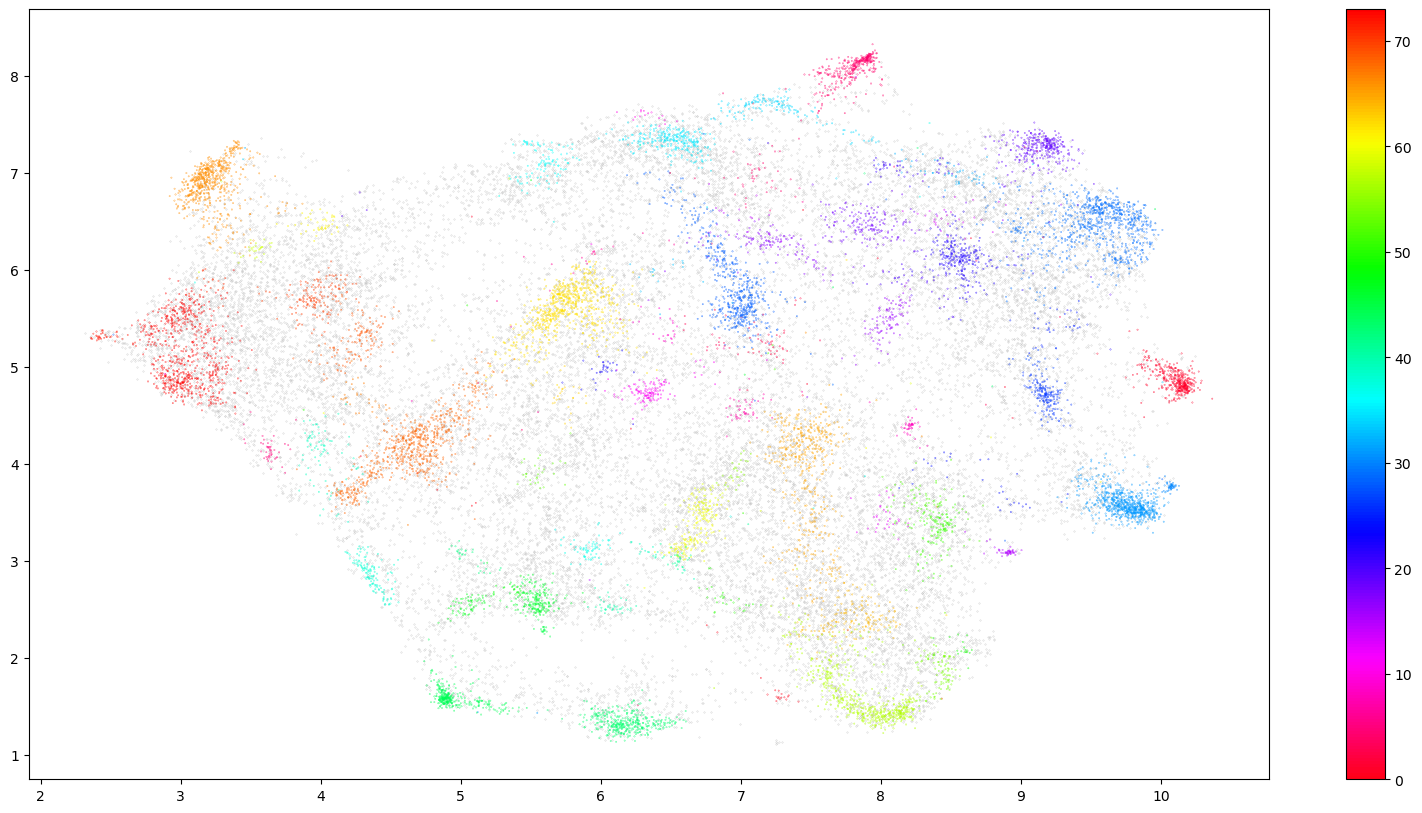

In [10]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

Number of clusters

In [8]:
len(set(cluster.labels_))

68

## Example of clusters

In [12]:
data['cluster'] = cluster.labels_

In [13]:
cluster_number = 3

cluster_docs = data[data['cluster'] == cluster_number]

for index, row in cluster_docs.head(5).iterrows():
    print(f"Document ID: {row['ID']}")
    print(f"Title: {row['Title']}")
    print(f"Summary: {row['Summary']}")
    print(f"Cluster: {row['cluster']}")
    print("-" * 80)

Document ID: http://arxiv.org/abs/1502.05615v1
Title: Forgetting and consolidation for incremental and cumulative knowledge   acquisition systems
Summary: The application of cognitive mechanisms to support knowledge acquisition is, from our point of view, crucial for making the resulting models coherent, efficient, credible, easy to use and understandable. In particular, there are two characteristic features of intelligence that are essential for knowledge development: forgetting and consolidation. Both plays an important role in knowledge bases and learning systems to avoid possible information overflow and redundancy, and in order to preserve and strengthen important or frequently used rules and remove (or forget) useless ones. We present an incremental, long-life view of knowledge acquisition which tries to improve task after task by determining what to keep, what to consolidate and what to forget, overcoming The Stability-Plasticity dilemma. In order to do that, we rate rules by in

## Histogram of clusters size

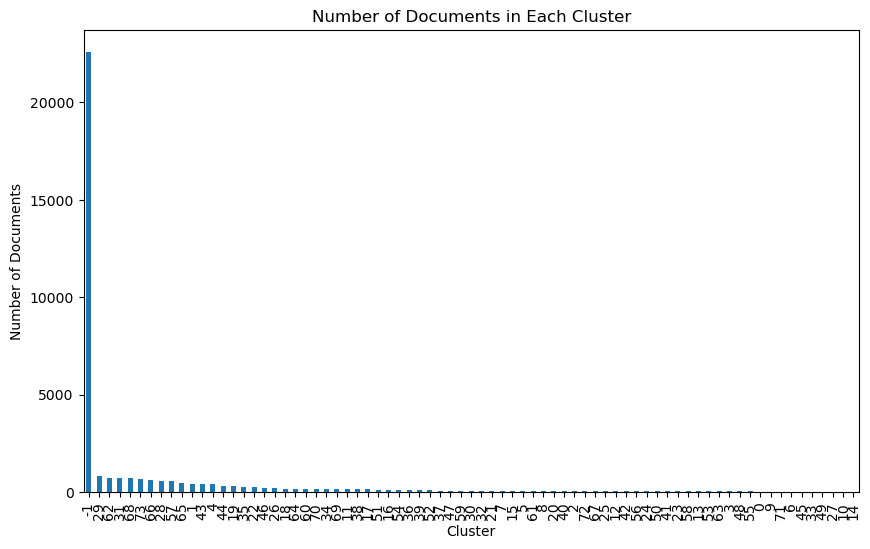

In [14]:
cluster_counts = data['cluster'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Documents')
plt.title('Number of Documents in Each Cluster')
plt.show()